In [1]:
import re
import numpy as np
import torch

In [2]:
def IoU(anchor, bbox):
    (x1, y1, x2, y2) = anchor
    (x3, y3, x4, y4) = bbox

    intersect_width = max(0.0, min(x2, x4) - max(x1, x3))
    intersect_height = max(0.0, min(y2, y4) - max(y1, y3))
    intersect = intersect_width * intersect_height
    return intersect / ((y2 - y1) * (x2 - x1) + (y4 - y3) * (x4 - x3) - intersect)

In [3]:
def nms(dets, cls, thresh):  #Non-maximum Suppression
    #[ : , 0 ] means (more or less) [ first_row:last_row , column_0 ].
    #If you have a 2-dimensional list/matrix/array,
    #this notation will give you all the values in column 0 (from all rows).
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = cls

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order.item(0)
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep


In [4]:
def parametrize(anchors, bboxes):
    reg = np.zeros(anchors.shape, dtype=np.float32)
    if not len(bboxes):
        return reg

    reg[:, 0] = 0.5 * (bboxes[:, 0] + bboxes[:, 2] - anchors[:, 0] - anchors[:, 2]) / (anchors[:, 2] - anchors[:, 0])
    reg[:, 1] = 0.5 * (bboxes[:, 1] + bboxes[:, 3] - anchors[:, 1] - anchors[:, 3]) / (anchors[:, 3] - anchors[:, 1])
    reg[:, 2] = np.log((bboxes[:, 2] - bboxes[:, 0]) / (anchors[:, 2] - anchors[:, 0]) )
    reg[:, 3] = np.log((bboxes[:, 3] - bboxes[:, 1]) / (anchors[:, 3] - anchors[:, 1]) )
    # print(reg)
    return reg

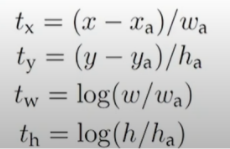

In [5]:
def unparametrize(anchors, reg):
    reg = reg.view(anchors.shape).float()
    bboxes = torch.zeros(anchors.shape, dtype=torch.float64)

    bboxes[:, 0] = (anchors[:, 2] - anchors[:, 0]) * reg[:, 0] + (anchors[:, 0] + anchors[:, 2]) / 2.0
    bboxes[:, 1] = (anchors[:, 3] - anchors[:, 1]) * reg[:, 1] + (anchors[:, 1] + anchors[:, 3]) / 2.0
    bboxes[:, 2] = (anchors[:, 2] - anchors[:, 0]) * torch.exp(reg[:, 2])
    bboxes[:, 3] = (anchors[:, 3] - anchors[:, 1]) * torch.exp(reg[:, 3])

    bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2] / 2.0
    bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3] / 2.0
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]

    return bboxes.float()

In [6]:
def count_positive_anchors_on_image(i, dataset):
    bboxes = dataset.get_truth_bboxes(i)
    anchors, _ = dataset.get_image_anchors()
    truth_bbox, positives, negatives = dataset.get_positive_negative_anchors(anchors, bboxes)
    print(anchors[np.where(positives)])
    return len(np.where(positives))